In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('stockmarket.csv')

In [3]:
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


## Data processing

In [4]:
import datetime
import calendar

def Date_trans(row):
    temp = row["Date"].split("-")
    temp[1] = list(calendar.month_abbr).index(temp[1])
    y = "-".join('%s' %id for id in temp)
    y = datetime.datetime.strptime(y, '%d-%m-%Y')
    return y

df["Date_T"] = df.apply (Date_trans , axis = 1)    

In [5]:
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,Date_T
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08


Mark out training set

In [6]:
def Train_Test(row):
    y = row["Date_T"].year
    if y < 2018:
        return "T"
    else:
        return "F"

df["Train"] = df.apply (Train_Test , axis = 1)    

In [7]:
df.tail()

,Date,Open Price,Close Price,High Price,Low Price,Volume,Date_T,Train
2511,24-Dec-2018,2400.56,2351.10,2410.34,2351.10,1662758784,2018-12-24,F
2512,26-Dec-2018,2363.12,2467.70,2467.76,2346.58,2611875072,2018-12-26,F
2513,27-Dec-2018,2442.50,2488.83,2489.10,2397.94,2386466304,2018-12-27,F
2514,28-Dec-2018,2498.77,2485.74,2520.27,2472.89,2080726656,2018-12-28,F
2515,31-Dec-2018,2498.94,2506.85,2509.24,2482.82,1912680064,2018-12-31,F


In [8]:
df['Train'].value_counts()

T    2264
F     252
Name: Train, dtype: int64

Convert to timestamp

In [9]:
def ToStamp(row):
    y = datetime.datetime.timestamp(row["Date_T"])
    return y

df["Time"] = df.apply (ToStamp , axis = 1)           

Calculate rise and fall percentage

In [10]:
def Rise_Fall_P(row):
    P = (row["Close Price"]/row["Open Price"]-1)*100
    return P

df["Diff"] = df.apply (Rise_Fall_P , axis = 1)

In [11]:
#df[["Date_T" , "Diff" , "Train"]]
Data = df.drop(["Date", "Close Price", "Date_T"], axis=1)
Data_train = Data[Data["Train"] == "T"].drop(["Train"], axis=1)
Data_test = Data[Data["Train"] == "F"].drop(["Train"], axis=1)

Seperate training and testing data set

In [12]:
x_train = Data_train.loc[:, Data_train.columns != "Diff"]
y_train = Data_train["Diff"]
x_test = Data_test.loc[:, Data_test.columns != "Diff"]
y_test = Data_test["Diff"]

In [13]:
x_train.head()

,Open Price,High Price,Low Price,Volume,Time
0,902.99,934.73,899.35,4048270080,1.230826e+09
1,929.17,936.63,919.53,5413910016,1.231085e+09
2,931.17,943.85,927.28,5392620032,1.231171e+09
3,927.45,927.45,902.37,4704940032,1.231258e+09
4,905.73,910.00,896.81,4991549952,1.231344e+09


## Linear regression

In [14]:
model = linear_model.LinearRegression(normalize=True)
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [15]:
train_pred = model.predict(x_train)
mse_train = metrics.mean_squared_error(y_train, train_pred)
print(mse_train)

0.2329952917956088


In [16]:
np.sqrt(mse_train)

0.4826958584819315

In [17]:
test_pred = model.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_pred)
print('test MSE: %s' % test_mse)
print('test RMSE: %s' % np.sqrt(test_mse))

test MSE: 0.4811992196290959
test RMSE: 0.6936852453592306


In [18]:
x_train.columns

Index(['Open Price', 'High Price', 'Low Price', 'Volume', 'Time'], dtype='object')

Scatter plot of selected training data

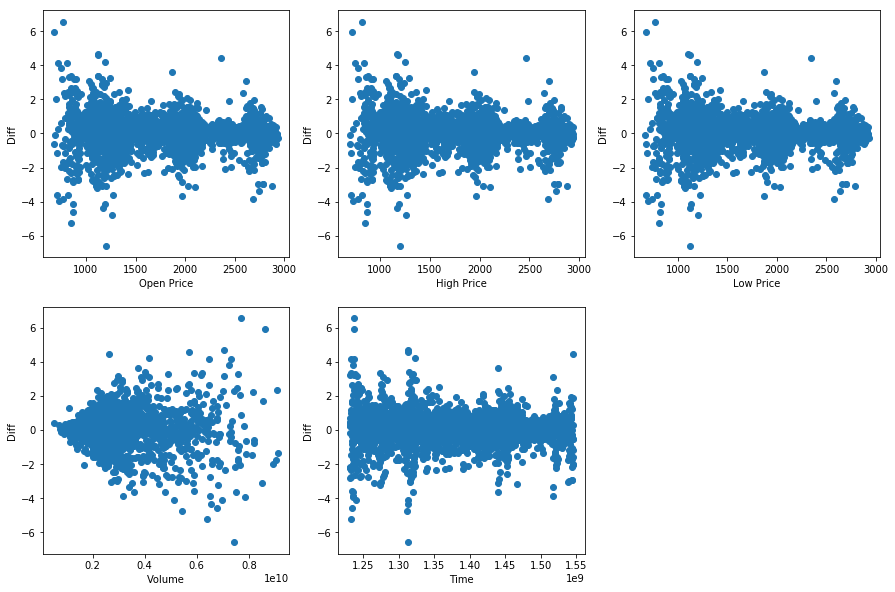

In [19]:
def scatter(_data, x_name):
    plt.scatter(_data[x_name], _data["Diff"])
    plt.xlabel(x_name)
    plt.ylabel("Diff")
    
plt.figure(figsize=(15,10))    
for i in range(len(x_train.columns)):
    plt.subplot(2,3,i+1),scatter(Data, x_train.columns[i])
plt.show()    

## Ridge Regression

In [20]:
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

Searching best 𝛼

In [21]:
alphas = np.linspace(start=0, stop=0.001, num=20)
alphas

array([0.00000000e+00, 5.26315789e-05, 1.05263158e-04, 1.57894737e-04,
       2.10526316e-04, 2.63157895e-04, 3.15789474e-04, 3.68421053e-04,
       4.21052632e-04, 4.73684211e-04, 5.26315789e-04, 5.78947368e-04,
       6.31578947e-04, 6.84210526e-04, 7.36842105e-04, 7.89473684e-04,
       8.42105263e-04, 8.94736842e-04, 9.47368421e-04, 1.00000000e-03])

In [22]:
mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())

In [23]:
mses

[0.2584873424502808,
 0.2902850473803974,
 0.3548381593752769,
 0.41659425946405193,
 0.47005317870393454,
 0.5153903546545059,
 0.5538377331388793,
 0.5866481988732767,
 0.614877763161926,
 0.6393713790410208,
 0.6607956240680951,
 0.6796762513472764,
 0.6964302346662752,
 0.7113908873163198,
 0.7248269766410388,
 0.7369571434244435,
 0.7479607855372411,
 0.7579863137748444,
 0.7671574588989745,
 0.7755781287806076]

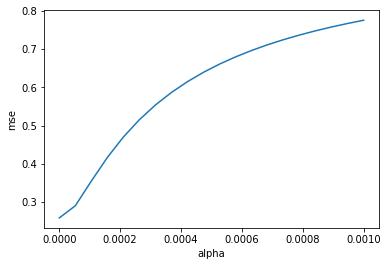

In [24]:
plt.plot(alphas, mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [25]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [26]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train, y_train)
train_preds = ridge.predict(x_train)
test_preds = ridge.predict(x_test)
train_mse = metrics.mean_squared_error(y_train, train_preds)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Train MSE: %s' % train_mse)
print('Test MSE: %s' % test_mse)

Train MSE: 0.2329952917956088
Test MSE: 0.4811992196321033


In [27]:
for i in range(0, len(Data_train.columns) - 1):
    print('Coefficient for %s:%s\t%s' %
          (Data_train.columns[i], 
           '\t' if len(Data_train.columns[i]) < 7 else '',
           ridge.coef_[i]))

Coefficient for Open Price:	-0.11142016153143013
Coefficient for High Price:	0.059895784938400976
Coefficient for Low Price:	0.05148738505146676
Coefficient for Volume:		-3.899915570309424e-12
Coefficient for Time:		5.421351050820676e-11


## Ridge regression + feature selection 
feature selection

In [28]:
wanted_features = ["Open Price", "High Price", "Low Price"] 
select_features = [column in wanted_features for column in x_train.columns]
x_train_fs = x_train.loc[:, select_features]

In [29]:
no_rr_model = linear_model.LinearRegression(normalize=True)
no_rr_model.fit(x_train_fs, y_train)
x_test_fs = x_test.loc[:, select_features]
no_rr_test_preds = no_rr_model.predict(x_test_fs)
metrics.mean_squared_error(y_test, no_rr_test_preds)

0.48217501724072837

Find best alpha

In [30]:
mses = []
alphas = np.linspace(start=0, stop=0.001, num=20)  # YOU CAN ALSO CHANGE THIS!
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train_fs, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())
best_alpha = alphas[np.argmin(mses)]
print(best_alpha)
print(min(mses))

0.0
0.25796847213289437


evaluate on test set

In [31]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train_fs, y_train)
test_preds = ridge.predict(x_test_fs)
metrics.mean_squared_error(y_test, test_preds)

0.4821750172435899